In [2]:
import pandas as pd
import torch

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub_fl = pd.read_csv("sample_submission.csv")
print(f"train = {train.shape}, test = {test.shape}, sample submission = {sub_fl.shape}")

train = (2190, 13), test = (730, 12), sample submission = (730, 2)


In [13]:
class Configuration:
    target = "rainfall"
    state = 42

In [15]:
Xtrain = train.drop(Configuration.target,axis=1)
ytrain = train[Configuration.target]
Xtest = test.copy()

Xtest["winddirection"] = Xtest["winddirection"].ffill()
Xtrain['day'] = train.id.mod(365) + 1
Xtest['day'] = test.id.mod(365) + 1
Xtrain["year_nb"] = Xtrain.index // 365

In [375]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

def tune_hyperparameter(model_class, fixed_params, param_name, param_values, Xtr, ytr, Xdev, ydev, scoring='accuracy'):
    """
    Tune a single hyperparameter using a validation set.

    Parameters:
        model_class: Class of the model (e.g., XGBClassifier, LogisticRegression)
        fixed_params: Dictionary of fixed hyperparameters
        param_name: Name of the hyperparameter to tune
        param_values: List of values to test for the hyperparameter
        Xtr: Training feature matrix
        ytr: Training target vector
        Xdev: Validation feature matrix
        ydev: Validation target vector
        scoring: Metric to optimize (default: 'accuracy')

    Returns:
        Dictionary with results, including best parameter and corresponding scores.
    """
    results = {
        'param_values': [],
        'train_scores': [],
        'dev_scores': []
    }

    if not param_values:
        print("No param values found, running without parameters")
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model_class())
        ])
        
        pipeline.fit(Xtr, ytr)

        train_score = roc_auc_score(ytr, pipeline.predict_proba(Xtr)[:,1])
        dev_score =roc_auc_score(ydev, pipeline.predict_proba(Xdev)[:,1])
        print(f"train_score = {train_score:.4f} | dev_score = {dev_score:.4f}")
        return
        
    for value in param_values:
        params = fixed_params.copy()
        params[param_name] = value
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model_class(**params))
        ])
        
        pipeline.fit(Xtr, ytr)

        train_score = roc_auc_score(ytr, pipeline.predict_proba(Xtr)[:,1])
        dev_score =roc_auc_score(ydev, pipeline.predict_proba(Xdev)[:,1])
        
        results['param_values'].append(value)
        results['train_scores'].append(train_score)
        results['dev_scores'].append(dev_score)
    
    best_index = np.argmax(results['dev_scores'])
    best_param = results['param_values'][best_index]
    best_score = results['dev_scores'][best_index]
    
    print(f"Best {param_name}: {best_param} with Validation Score: {best_score:.4f}")
    
    plt.figure(figsize=(8, 5))
    plt.plot(results['param_values'], results['train_scores'], marker='s', linestyle='--', label='Training Score')
    plt.plot(results['param_values'], results['dev_scores'], marker='^', linestyle='-.', label='Validation Score')
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.legend()
    plt.title(f"Hyperparameter Tuning: {param_name}")
    plt.show()
    
    return results

In [203]:
drop_columns = ['id',Configuration.target,'year_nb']

In [204]:
Xtr = Xtrain.loc[Xtrain['year_nb'] <= 3].drop(drop_columns,axis=1,errors="ignore")
Xdev = Xtrain.loc[Xtrain['year_nb'] > 3].drop(drop_columns,axis=1,errors="ignore")
ytr = ytrain.loc[Xtr.index]
ydev = ytrain.loc[Xdev.index]

In [389]:
HYPER_PARAMETERS = \
{
    "XGBC": \
    {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "random_state": Configuration.state,
        "n_estimators": 200,
        "max_depth": 3,
        "learning_rate": 0.02,
        "min_child_weight": 14,
        "colsample_bytree": 0.8,
        "reg_lambda": 0,
        "subsample": 0.8,        
    },

    "CBC": \
    {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",        
        "depth": 3,
        "learning_rate": 0.01,      
        "iterations": 200,
        "l2_leaf_reg": 0,
        "subsample": 0.8,
        "verbose": 0,
        "random_state": Configuration.state,        
    },

    "HGBC": \
    {
        "loss": "log_loss",
        "learning_rate": 0.02,
        "max_iter": 300,
        "max_depth": 3,
        "min_samples_leaf": 250,
        "scoring": "roc_auc",
        "random_state": Configuration.state
    },
    
    "LGBC": \
    {
        "objective": "binary",
        "metric": "auc",
        "num_leaves": 5,
        "max_depth": 10,
        "learning_rate": 0.02,
        "n_estimators": 200,
        "min_child_samples": 250,
        "colsample_bytree": 0.5, 
        "subsample": 0.5,
        "reg_lambda": 0,
        "verbose": -1,
        "random_state": Configuration.state,
    },    

    "RFC": \
    {
        "criterion": "log_loss",
        "n_estimators": 40,
        "max_depth": 5,
        "min_samples_leaf": 40,
        "min_weight_fraction_leaf": 0.0,
        "random_state": Configuration.state,
    },  

    "LRC": \
    {
        "penalty": "l2",
        "C": 0.005
    },      

    "KNNC": \
    {
        "n_neighbors": 100,        
    },

    "TPFNC": \
    {},        
}        

In [390]:
MODELS = \
{
    "XGBC": xgboost.XGBClassifier,
    "LGBC": lightgbm.LGBMClassifier,
    "CBC": catboost.CatBoostClassifier,
    "HGBC": sklearn.ensemble.HistGradientBoostingClassifier,
    "RFC": sklearn.ensemble.RandomForestClassifier,
    "LRC": sklearn.linear_model.LogisticRegression,
    "KNNC": sklearn.neighbors.KNeighborsClassifier,
    "TPFNC": tabpfn.TabPFNClassifier,
}

Best n_neighbors: 100 with Validation Score: 0.8715


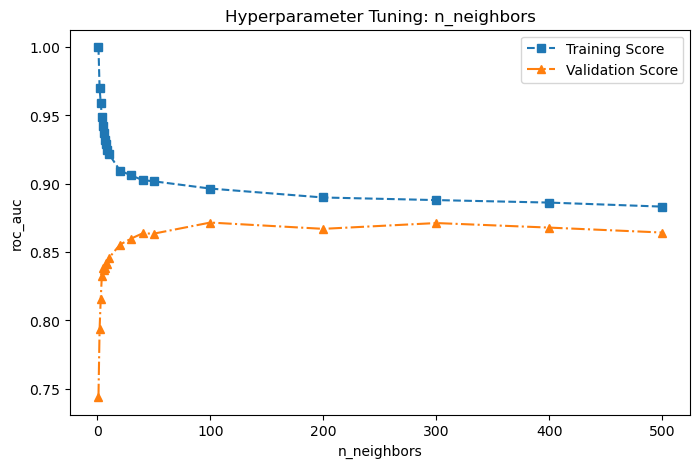

{'param_values': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  20,
  30,
  40,
  50,
  100,
  200,
  300,
  400,
  500],
 'train_scores': [1.0,
  0.969988975239918,
  0.9594155643961909,
  0.9490369983055906,
  0.9419128328700632,
  0.9372192940700602,
  0.9319202567017961,
  0.928720116610885,
  0.9244162673171357,
  0.9220892290313749,
  0.9096129988580619,
  0.906046599959058,
  0.9026479155311,
  0.9017365846921083,
  0.8964190494042437,
  0.889891750174497,
  0.8879913972341911,
  0.8861650359722877,
  0.8832152343933052],
 'dev_scores': [0.7437806447495772,
  0.793503578987673,
  0.8153657161697918,
  0.8327554482509227,
  0.8379670499143809,
  0.8366854213420405,
  0.8382223120366727,
  0.8417534380617095,
  0.8413652269173908,
  0.8453536975782007,
  0.8553567819955116,
  0.8598398230182619,
  0.8636208932047095,
  0.8634347645738718,
  0.8715393369566373,
  0.8669393007945034,
  0.871183033577605,
  0.867853990066049,
  0.864248412588677]}

In [362]:
# import sklearn.neighbors

# tune_hyperparameter(model_class=sklearn.neighbors.KNeighborsClassifier,fixed_params=HYPER_PARAMETERS["KNNC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "n_neighbors",param_values = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,200,300,400,500])

Best C: 0.005 with Validation Score: 0.8850


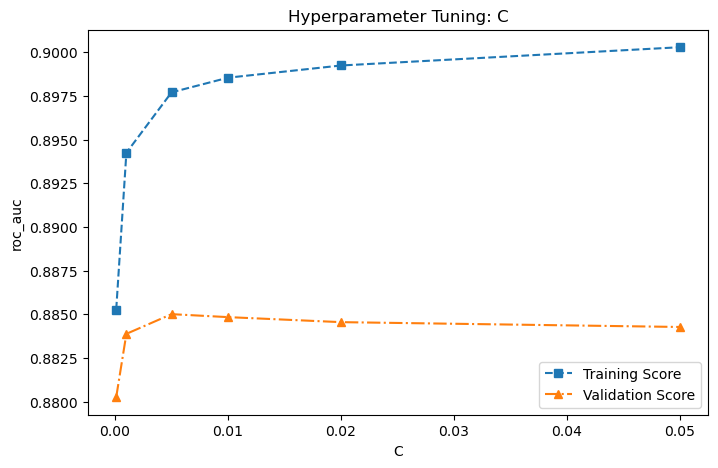

{'param_values': [0.0001, 0.001, 0.005, 0.01, 0.02, 0.05],
 'train_scores': [0.8852660370796965,
  0.8942387612806478,
  0.8976991054406082,
  0.898537677795837,
  0.8992356659621015,
  0.9002814150168578],
 'dev_scores': [0.880250156879846,
  0.8838770062007424,
  0.8850044139075313,
  0.8848342391593367,
  0.8845470692717583,
  0.8842705353059424]}

In [385]:
import sklearn.linear_model 

tune_hyperparameter(model_class=sklearn.linear_model.LogisticRegression,fixed_params=HYPER_PARAMETERS["LRC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
                    param_name = "C",param_values = [1e-4,1e-3,5e-3,1e-2,2e-2,5e-2])

In [341]:
# tune_hyperparameter(model_class=sklearn.ensemble.RandomForestClassifier,fixed_params=HYPER_PARAMETERS["RFC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "n_estimators",param_values = [2,5,10,20,30,40,50,60,70,80,90,100])

# tune_hyperparameter(model_class=sklearn.ensemble.RandomForestClassifier,fixed_params=HYPER_PARAMETERS["RFC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "max_depth",param_values = [2,3,4,5,6,7,8,9,10,11,12])

# tune_hyperparameter(model_class=sklearn.ensemble.RandomForestClassifier,fixed_params=HYPER_PARAMETERS["RFC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "min_samples_leaf",param_values = np.arange(1,400,10))

In [314]:
# import sklearn.ensemble

# tune_hyperparameter(model_class=sklearn.ensemble.HistGradientBoostingClassifier,fixed_params=HYPER_PARAMETERS["HGBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "max_depth",param_values = [2,3,4,5,6])   

# tune_hyperparameter(model_class=sklearn.ensemble.HistGradientBoostingClassifier,fixed_params=HYPER_PARAMETERS["HGBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "max_iter",param_values = [50,100,200,300,400,500,1000])

# tune_hyperparameter(model_class=sklearn.ensemble.HistGradientBoostingClassifier,fixed_params=HYPER_PARAMETERS["HGBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "learning_rate",param_values = [0.001,0.002,0.005,0.01,0.02,0.05])   

# tune_hyperparameter(model_class=sklearn.ensemble.HistGradientBoostingClassifier,fixed_params=HYPER_PARAMETERS["HGBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "min_samples_leaf",param_values = np.arange(1,700,10))


# tune_hyperparameter(model_class=sklearn.ensemble.HistGradientBoostingClassifier,fixed_params=HYPER_PARAMETERS["HGBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "l2_regularization",param_values = [0.001,0.1,0.2,0.4,0.5,0.6,0.7,0.8,0.9,1])   

In [219]:
# import catboost

# tune_hyperparameter(model_class=catboost.CatBoostClassifier,fixed_params=HYPER_PARAMETERS["CBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "depth",param_values = [2,3,4,5,6])   

# tune_hyperparameter(model_class=catboost.CatBoostClassifier,fixed_params=HYPER_PARAMETERS["CBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "learning_rate",param_values = [0.001,0.002,0.005,0.01,0.02,0.05])   

# tune_hyperparameter(model_class=catboost.CatBoostClassifier,fixed_params=HYPER_PARAMETERS["CBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "iterations",param_values = [50,100,200,300,400,500,1000])

# tune_hyperparameter(model_class=catboost.CatBoostClassifier,fixed_params=HYPER_PARAMETERS["CBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "subsample", param_values = np.linspace(0.3,1,20))

# tune_hyperparameter(model_class=catboost.CatBoostClassifier,fixed_params=HYPER_PARAMETERS["CBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "colsample_bylevel", param_values = np.linspace(0.1,1,10))

# tune_hyperparameter(model_class=catboost.CatBoostClassifier,fixed_params=HYPER_PARAMETERS["CBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "l2_leaf_reg", param_values = np.linspace(0.1,1,10))

In [313]:
import lightgbm

# tune_hyperparameter(model_class=lightgbm.LGBMClassifier,fixed_params=HYPER_PARAMETERS["LGBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "num_leaves",param_values = np.arange(2,10,1))   

# tune_hyperparameter(model_class=lightgbm.LGBMClassifier,fixed_params=HYPER_PARAMETERS["LGBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "max_depth",param_values = [2,3,4,5,6,7])   

# tune_hyperparameter(model_class=lightgbm.LGBMClassifier,fixed_params=HYPER_PARAMETERS["LGBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "learning_rate",param_values = [0.001,0.002,0.005,0.01,0.02,0.05]) 

# tune_hyperparameter(model_class=lightgbm.LGBMClassifier,fixed_params=HYPER_PARAMETERS["LGBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "n_estimators",param_values = np.arange(10,1000,10)) 

# tune_hyperparameter(model_class=lightgbm.LGBMClassifier,fixed_params=HYPER_PARAMETERS["LGBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "min_child_samples", param_values = np.arange(1,720,25))

# tune_hyperparameter(model_class=lightgbm.LGBMClassifier,fixed_params=HYPER_PARAMETERS["LGBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "colsample_bytree", param_values = np.linspace(.1,1,11))

# tune_hyperparameter(model_class=lightgbm.LGBMClassifier,fixed_params=HYPER_PARAMETERS["LGBC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "subsample", param_values = np.linspace(.1,1,11))

In [232]:
import xgboost 

# tune_hyperparameter(model_class=xgboost.XGBClassifier,fixed_params=HYPER_PARAMETERS["XGB"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "n_estimators",param_values = [50,100,200,300,500,1000])                    

# tune_hyperparameter(model_class=xgboost.XGBClassifier,fixed_params=HYPER_PARAMETERS["XGB"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "learning_rate",param_values = [0.001,0.005,0.01,0.02,0.05])

# tune_hyperparameter(model_class=xgboost.XGBClassifier,fixed_params=HYPER_PARAMETERS["XGB"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "max_depth", param_values = [1,2,3,4,5,6,7,8])

# tune_hyperparameter(model_class=xgboost.XGBClassifier,fixed_params=HYPER_PARAMETERS["XGB"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "subsample", param_values = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

# tune_hyperparameter(model_class=xgboost.XGBClassifier,fixed_params=HYPER_PARAMETERS["XGB"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "min_child_weight", param_values = [1,2,4,6,8,10,12,14,16,18,20,22,24,26,28])

# tune_hyperparameter(model_class=xgboost.XGBClassifier,fixed_params=HYPER_PARAMETERS["XGB"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "colsample_bytree", param_values = [0.5,0.6,0.7,0.8,0.9,1])

# tune_hyperparameter(model_class=xgboost.XGBClassifier,fixed_params=HYPER_PARAMETERS["XGB"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
#                     param_name = "reg_lambda", param_values = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

In [381]:
# tune_hyperparameter(model_class=tabpfn.TabPFNClassifier,fixed_params=HYPER_PARAMETERS["TPFNC"],Xtr = Xtr,ytr = ytr,Xdev=Xdev,ydev=ydev,scoring="roc_auc",
                    # param_name = None,param_values = [])  

In [399]:
def train_and_predict(models, hyperparameters, Xtrain, ytrain, Xtest, ytest=None):
    trained_models = {}
    test_probs = []

    # Standardize data
    scaler = StandardScaler()
    Xtrain_scaled = scaler.fit_transform(Xtrain)
    Xtest_scaled = scaler.transform(Xtest)    

    # Train each model and store predictions
    for name, Model in models.items():
        print(f"Training {name}...")
        
        # Initialize model with hyperparameters
        model = Pipeline([
            ('scaler', StandardScaler()), 
            ('classifier', Model(**hyperparameters.get(name, {})))
        ])
        
        # Fit model
        model.fit(Xtrain, ytrain)
        
        # Store trained model
        trained_models[name] = model
        
        # Get probability predictions for class 1
        prob_pred = model.predict_proba(Xtest)[:, 1]

        # Print validation score if applicable
        if ytest is not None:
            test_score = roc_auc_score(ytest, prob_pred)
            print(f"{name} Test AUC: {test_score:.4f}\n")        
            
        test_probs.append(prob_pred)

    # Average predictions
    avg_probs = np.mean(test_probs, axis=0)

    # Compute test score if ytest is provided
    test_score = None
    if ytest is not None:
        test_score = roc_auc_score(ytest, avg_probs)
        print(f"Ensemble Test AUC: {test_score:.4f}")

    return avg_probs

In [401]:
train_and_predict(models=MODELS,hyperparameters=HYPER_PARAMETERS,
                  Xtrain=Xtr,ytrain=ytr,Xtest=Xdev,ytest=ydev);

Training XGBC...
XGBC Test AUC: 0.8798

Training LGBC...
LGBC Test AUC: 0.8765

Training CBC...
CBC Test AUC: 0.8798

Training HGBC...
HGBC Test AUC: 0.8741

Training RFC...
RFC Test AUC: 0.8804

Training LRC...
LRC Test AUC: 0.8850

Training KNNC...
KNNC Test AUC: 0.8715

Training TPFNC...
TPFNC Test AUC: 0.8801

Ensemble Test AUC: 0.8821


In [404]:
Xtrain_full = Xtrain.drop(drop_columns,axis=1,errors="ignore")
Xtest_full = Xtest.drop(drop_columns,axis=1,errors="ignore")

In [405]:
y_pred = train_and_predict(models=MODELS,hyperparameters=HYPER_PARAMETERS,
                  Xtrain=Xtrain_full,ytrain=ytrain,Xtest=Xtest_full);

Training XGBC...
Training LGBC...
Training CBC...
Training HGBC...
Training RFC...
Training LRC...
Training KNNC...
Training TPFNC...


In [409]:
sub_fl['rainfall'] = y_pred

In [412]:
sub_fl.to_csv("prediction.csv",index=False)